### NOW EXPERIMENTING:
Pinet: 
* increase valid data to 0.2, close early stopping, ajust delay ramp up to epoch/2
* check iou_metrix function
* try SGD, its noiser
* set higher w = 1.0, ramp up delay to 50, ramp up peroid to 50, only sample 3600 test dataset
* change core model

### Done:
* regularized by pseudo labeled data, but it also have some lagecy label which seems in the eraly stage, seems wrong
* try pure training dataset, should be same to normal train
* noise and rotation cause huge performance decrease.....
* randomize in first batch otherwise loss seems a bit strange.
* add some random noice
* custom data generate to update test temperal mask every n epoch
* change unsupervise loss weight on the fly
* used full model (without dropout) for validation and prediction
* close augmentation: noise, rotation, no temperal predict, no temperal loss
* ramp-up function is also important as early psuedo label is very wrong, reduced temperal loss in early stage, otherwise network will learn wrong pattern from early stage psuedo label
* train on train then test order, insure frist part of training has all label, which won't confuse network, solution: use a ration to adjust how much label vs unlabel loss will go into total loss (unlabled size / batch size) * w
* loss is toooooooo high without any reason: its cause by test data, when update weight with test data which don't have label, it cause network confuse because those update don't have gradient, (are based on other's graident)...
* sample data(train + test) from db, split train data into train val data
* apply test data mask if its none (no temperal mask)
* basic augmentation twice for pinet
* custom pi net loss function
* move prediction into here as it used custom function

### work: 
* image data augmentation, flip, crop,
* resnet with high dropout, (as resnet so easy overfitting, and not enough data)
* 2d spatial dropout
* dice loss, faster converge, but doesn't help improve score....

### not work:
* deeper, shellower
* Clahe
* pure dice loss, it will give binary solution, rather than probability
* dropout=0.6, overfitting, Val=0.8, LB=0.77

### idea:
* augmentation: rotation, affine transform, Elastic deformations
* reduce dropout, as always under fitting
* smaller batch size
* CRF
* inception block


In [1]:
# iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

# def iou(img_true, img_pred):
#     i = np.sum((img_true*img_pred) >0)
#     u = np.sum((img_true + img_pred) >0)
#     if u == 0:
#         return u
#     return i/u

# def iou_metric(imgs_true, imgs_pred):
#     num_images = len(imgs_true)
#     scores = np.zeros(num_images)
    
#     for i in range(num_images):
#         if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
#             scores[i] = 1
#         else:
#             scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
#     return scores.mean()

In [2]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage import transform
from skimage import util
from tqdm import tqdm_notebook
import skimage as sk
import gc
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import keras
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend, common
from keras.callbacks import LambdaCallback, Callback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [4]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}], allowDiskUse=True)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Put all dataset into DF frist, hold in memory

In [5]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})

############# sample or all test data from db #############
# test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]}, num_sample=3600)

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)
# test_df = test_df.drop('img_mask_base64', axis=1)
# test_df = test_df.drop('ASM', axis=1)
# test_df = test_df.drop('contrast', axis=1)
# test_df = test_df.drop('correlation', axis=1)
# test_df = test_df.drop('dissimilarity', axis=1)
# test_df = test_df.drop('energy', axis=1)
# test_df = test_df.drop('entropy', axis=1)
# test_df = test_df.drop('homogeneity', axis=1)
# test_df = test_df.drop('coverage', axis=1)
# test_df = test_df.drop('coverage_class', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.2)

############# use test + train or only train data #############
train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)
# train_test_df = train_df.copy()

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_test_df.shape)

(3200, 7)
(800, 7)
(3600, 17)
(6800, 17)


In [6]:
# train_test_df.head(-1)

# Data Preprcessing function: sample, augment, to np_array

In [7]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.0005
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.01
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      scale = 0.05
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss * scale
      return noisy
   elif noise_typ == 'None':
      return image

def _img_augmentation(_df, if_augment=True):
    def random_crop_resize(x, crop, flip, degree, noise_type='None'):
        # return x if all pixel is -1
        if np.mean(x) == -1:
            return x
        
        x = np.fliplr(x) if flip else x
        
        ######### noise, rotate decrease the performance a lot... ###########
#         x = np.squeeze(noisy(noise_type, np.expand_dims(x, axis=3)))
#         x = sk.transform.rotate(x, degree)
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in df.iterrows():
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=30, size=4) if if_augment else np.array([0, 1, 0, 1])
            flip = np.random.choice([True, False]) if if_augment else False
            degree = np.random.uniform(-10, 10) if if_augment else 0
            noise_type = np.random.choice(['gauss', 'poisson', 's&p', 'speckle', 'None']) if if_augment else 'None'
            
            aug_img = random_crop_resize(row['img'], crop, flip, degree, noise_type)
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip, degree)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip, degree)

            
            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    _augment_df = img_augment(_df)
    
    return _augment_df

def _convert_to_np_array(_augment_df):
    X_np = np.expand_dims(np.stack((np.asarray(_augment_df['aug_img'].values.tolist()))),axis=3)
    y_np = np.expand_dims(np.asarray(_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_temp_np = np.expand_dims(np.asarray(_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_np = np.concatenate((y_np,y_temp_np),axis=3)
    
    return X_np, y_np

def calculate_temperal_mask(epoch):
    global model_train, train_df, test_df, graph_train
    with graph_train.as_default():
        X_train = np.expand_dims(np.stack((np.asarray(train_df['img'].values.tolist()))),axis=3)
        predict_train = model_train.predict(X_train,batch_size=64, verbose=1)
        predict_train = np.squeeze(predict_train)
        
        X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
        predict_test = model_train.predict(X_test,batch_size=64, verbose=1)
        predict_test = np.squeeze(predict_test)
    
    idx = 0;
    alpha = 0.5
#     temperal_mask_ramp_up = 1/(1-(alpha**(epoch+1)))
    for index, row in tqdm_notebook(train_df.iterrows(),total=len(train_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_train[idx]; idx+=1;
        if(np.mean(img_temperal_mask) < 0):
            train_df.at[index,'img_temperal_mask'] = predict
        else:
            train_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
            
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) < 0):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
    
    train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)

    return train_test_df

# plot some augmented image

In [8]:
# sample_train_df = train_df.sample(50)
# train_augment_df = _img_augmentation(sample_train_df)

# %%time
# sample_train_df, sample_val_df, sample_test_df = sample_df(train_df, val_df, test_df)
# train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
# X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)


In [9]:
# test_augment_df.head(1)
# train_augment_df.head(10)

In [10]:
# base_idx = 0
# max_images = 16
# grid_width = 4
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
# row = 0; col = 0;
# for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
#     img = train_augment_df.loc[idx].aug_img
#     mask = train_augment_df.loc[idx].aug_img_mask
    
#     ax = axs[row, col];
#     ax.imshow(img, cmap="seismic")
# #     ax.imshow(img, cmap="gray")
#     ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
#     ax.set_yticklabels([]); ax.set_xticklabels([]);
    
#     if col >= grid_width:
#         col=0; row+=1;


# Custom loss function

In [11]:
from debug import _debug_func

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):

    def mse_loss(y_pred, y_temperal, temperal_size):
        # generate filter using y_temperal
        temperal_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_temperal, -1), tf.float32))

        # filter out MSE if temperal = -1
        quad_diff = K.sum((temperal_filter*y_pred - temperal_filter*y_temperal) ** 2) / (temperal_size*128*128+1e-15)

        return quad_diff

    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])

    # count temperal size which has value (not -1)
    temperal_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32)))

    quad_diff = tf.cond(temperal_size > 0, lambda: mse_loss(y_pred, y_temperal, temperal_size), lambda: 0.0)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
#     y_mask = _debug_func((y_mask),"y_mask")

    # count mask size
    mask_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_mask, -1), tf.float32))

    y_mask = y_mask*mask_filter
    y_pred = y_pred*mask_filter
    
    bce_loss_ = tf.cond(mask_size > 0, lambda: (K.sum(binary_crossentropy(y_mask, y_pred))/(mask_size*128*128+1e-15)), lambda: 0.0)    
    dice_loss_ = dice_loss(y_mask, y_pred)
    
    bce_dice_loss_ = bce_loss_ + dice_loss_

    return bce_dice_loss_

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*(tf.cast(tf.greater(y_temperal,0.5), tf.float32)), temperal_filter*y_pred)
    return temperal_mean_iou

class Temperal_Callback(Callback):
    def __init__(self, delay_temperal=0, ramp_up_period=50):
        self.ramp_up = 0
        self.ramp_up_period = ramp_up_period
        self.w = 1.0
        self.delay_temperal = delay_temperal
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch-self.delay_temperal < 0:
            self.ramp_up = 0
        elif epoch-self.delay_temperal < self.ramp_up_period:
            self.ramp_up = np.exp(-5*((1-((epoch-self.delay_temperal)/self.ramp_up_period)))**2)
        else:
            self.ramp_up = 1
        logger.info("epoch %s, ramp_up = %s" % (epoch, self.ramp_up))

    def temporal_loss(self, y_true, y_pred):
        sup_loss = masked_crossentropy(y_true, y_pred)
        unsup_loss = temperal_mse_loss(y_true, y_pred)

        batch_size = tf.stop_gradient(tf.to_float(tf.shape(y_pred)[0]))
        y_mask = tf.stop_gradient(tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1]))
        mask_size = tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))
        
        w = self.w * (1.0-(mask_size/batch_size)) * self.ramp_up
#         sup_loss = _debug_func((sup_loss),"sup_loss")
#         unsup_loss = _debug_func((unsup_loss),"unsup_loss")
        
        ######## use sup+unsup or only sup loss########
#         return sup_loss
        return sup_loss + w * unsup_loss

# DataGenerator

In [12]:
class DataGenerator(keras.utils.Sequence):
    #class static variable
    global model_train
    _val_df = None
    _train_test_df = None
    _X_train = None
    _y_train = None
    _X_valid = None
    _y_valid = None
    
    'Generates data for Keras'
    def __init__(self, train_test_df, val_df, 
                 batch_size=32, shuffle=True, training=True, temperal_every_epoch=1, delay_temperal=0):
        self.training = training
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = 0
        self.val_size = val_df.shape[0]
        self.train_test_size = train_test_df.shape[0]
        self.temperal_every_epoch = temperal_every_epoch
        self.delay_temperal = delay_temperal
        
        print(f'val_size = {self.val_size}, \
              train_test_size = {self.train_test_size}, \
              ')
        
        'Initial static variable'
        if self.training:
            DataGenerator._val_df = val_df
            DataGenerator._train_test_df = train_test_df

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.training:
            print('train lenght')
            print(int(np.floor((self.train_test_size) / self.batch_size)))
            return int(np.floor((self.train_test_size) / self.batch_size))
        else:
            print('val lenght')
            print(int(np.floor(self.val_size / self.batch_size)))
            return int(np.floor(self.val_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        'index: indicate which batch in a epoch, (first, second or third batch)'
        # Generate indexes of the batch
        if self.training:            
            batch_train_df = DataGenerator._train_test_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            train_augment_df = _img_augmentation(batch_train_df)
            X_train_np, y_train_np = _convert_to_np_array(train_augment_df)
            
            return X_train_np, y_train_np
        else:
            batch_val_df = DataGenerator._val_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            val_augment_df = _img_augmentation(batch_val_df, if_augment=False)
            X_val_np, y_val_np = _convert_to_np_array(val_augment_df)
            
            del batch_val_df, val_augment_df
            
            return X_val_np, y_val_np

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        print(f', epoch={self.epoch}')
        if self.epoch % self.temperal_every_epoch == 0 and self.training and self.epoch >= self.delay_temperal:
            new_train_test_df = calculate_temperal_mask(self.epoch)
            DataGenerator._train_test_df = new_train_test_df
        self.epoch += 1

# Build Unet + Resnet

In [13]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [14]:
# used for training unsuperivsed, that keep dropout
global model_train, graph_train

epochs = 100
batch_size = 32
dropout = 0.6

####### control when to start temperal ensemble #############
delay_temperal = epochs/2
####### control how many epoch that ramp up from 0 to 1 #########
ramp_up_period = epochs/2

temperal = Temperal_Callback(delay_temperal=delay_temperal, ramp_up_period=ramp_up_period)
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=dropout, training=True)
model_train.compile(loss=temperal.temporal_loss, optimizer=keras.optimizers.Adam(), metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()
graph_train = tf.get_default_graph()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [15]:
callbacks = [
    temperal,
#     EarlyStopping(patience=10, verbose=1, monitor="loss", mode="min"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="loss", mode="min"),
    ModelCheckpoint('weight-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="loss", mode="min", save_weights_only=True),
]

training_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=True, delay_temperal=delay_temperal)
validation_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=False, delay_temperal=delay_temperal)

history = model_train.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs, callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=4)

val_size = 800,               train_test_size = 6800,               
val_size = 800,               train_test_size = 6800,               
val lenght
25
train lenght
212
train lenght
212
Epoch 1/100
211/212 [============================>.] - ETA: 0s - loss: 0.8892 - masked_crossentropy: 0.8892 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6032 - temperal_mean_iou: 0.9953, epoch=0
val lenght
25
val lenght
25
, epoch=0
212/212 [==============================] - 64s 302ms/step - loss: 0.8889 - masked_crossentropy: 0.8889 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6035 - temperal_mean_iou: 0.9953 - val_loss: 0.8599 - val_masked_crossentropy: 0.8599 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6510 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 0, ramp_up = 0



Epoch 00001: loss improved from inf to 0.88893, saving model to model-u-res-pi-net.h5

Epoch 00001: loss improved from inf to 0.88893, saving model to weight-u-res-pi-net.h5
Epoch 2/100
211/212 [============================>.] - ETA: 0s - loss: 0.7114 - masked_crossentropy: 0.7114 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6638 - temperal_mean_iou: 1.0000, epoch=1
val lenght
25
val lenght
25
, epoch=1
212/212 [==============================] - 51s 238ms/step - loss: 0.7107 - masked_crossentropy: 0.7107 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6639 - temperal_mean_iou: 1.0000 - val_loss: 0.6895 - val_masked_crossentropy: 0.6895 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6836 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 1, ramp_up = 0



Epoch 00002: loss improved from 0.88893 to 0.71069, saving model to model-u-res-pi-net.h5

Epoch 00002: loss improved from 0.88893 to 0.71069, saving model to weight-u-res-pi-net.h5
Epoch 3/100
211/212 [============================>.] - ETA: 0s - loss: 0.6577 - masked_crossentropy: 0.6577 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6936 - temperal_mean_iou: 1.0000, epoch=2
val lenght
25
val lenght
25
, epoch=2
212/212 [==============================] - 49s 230ms/step - loss: 0.6564 - masked_crossentropy: 0.6564 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6937 - temperal_mean_iou: 1.0000 - val_loss: 0.6354 - val_masked_crossentropy: 0.6354 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7035 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 2, ramp_up = 0



Epoch 00003: loss improved from 0.71069 to 0.65638, saving model to model-u-res-pi-net.h5

Epoch 00003: loss improved from 0.71069 to 0.65638, saving model to weight-u-res-pi-net.h5
Epoch 4/100
211/212 [============================>.] - ETA: 0s - loss: 0.6011 - masked_crossentropy: 0.6011 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7121 - temperal_mean_iou: 1.0000, epoch=3
val lenght
25
val lenght
25
, epoch=3
212/212 [==============================] - 48s 227ms/step - loss: 0.5997 - masked_crossentropy: 0.5997 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7121 - temperal_mean_iou: 1.0000 - val_loss: 0.7566 - val_masked_crossentropy: 0.7566 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7159 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 3, ramp_up = 0



Epoch 00004: loss improved from 0.65638 to 0.59971, saving model to model-u-res-pi-net.h5

Epoch 00004: loss improved from 0.65638 to 0.59971, saving model to weight-u-res-pi-net.h5
Epoch 5/100
211/212 [============================>.] - ETA: 0s - loss: 0.5736 - masked_crossentropy: 0.5736 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7185 - temperal_mean_iou: 1.0000, epoch=4
val lenght
25
val lenght
25
, epoch=4
212/212 [==============================] - 48s 227ms/step - loss: 0.5719 - masked_crossentropy: 0.5719 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7185 - temperal_mean_iou: 1.0000 - val_loss: 0.6062 - val_masked_crossentropy: 0.6062 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7236 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 4, ramp_up = 0



Epoch 00005: loss improved from 0.59971 to 0.57190, saving model to model-u-res-pi-net.h5

Epoch 00005: loss improved from 0.59971 to 0.57190, saving model to weight-u-res-pi-net.h5
Epoch 6/100
211/212 [============================>.] - ETA: 0s - loss: 0.5502 - masked_crossentropy: 0.5502 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7288 - temperal_mean_iou: 1.0000, epoch=5
val lenght
25
val lenght
25
, epoch=5
212/212 [==============================] - 48s 227ms/step - loss: 0.5512 - masked_crossentropy: 0.5512 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7288 - temperal_mean_iou: 1.0000 - val_loss: 0.6370 - val_masked_crossentropy: 0.6370 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7317 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 5, ramp_up = 0



Epoch 00006: loss improved from 0.57190 to 0.55124, saving model to model-u-res-pi-net.h5

Epoch 00006: loss improved from 0.57190 to 0.55124, saving model to weight-u-res-pi-net.h5
Epoch 7/100
211/212 [============================>.] - ETA: 0s - loss: 0.5224 - masked_crossentropy: 0.5224 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7348 - temperal_mean_iou: 1.0000, epoch=6
val lenght
25
val lenght
25
, epoch=6
212/212 [==============================] - 48s 227ms/step - loss: 0.5224 - masked_crossentropy: 0.5224 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7348 - temperal_mean_iou: 1.0000 - val_loss: 0.5500 - val_masked_crossentropy: 0.5500 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7388 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 6, ramp_up = 0



Epoch 00007: loss improved from 0.55124 to 0.52240, saving model to model-u-res-pi-net.h5

Epoch 00007: loss improved from 0.55124 to 0.52240, saving model to weight-u-res-pi-net.h5
Epoch 8/100
211/212 [============================>.] - ETA: 0s - loss: 0.5170 - masked_crossentropy: 0.5170 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7420 - temperal_mean_iou: 1.0000, epoch=7
val lenght
25
val lenght
25
, epoch=7
212/212 [==============================] - 48s 228ms/step - loss: 0.5170 - masked_crossentropy: 0.5170 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7420 - temperal_mean_iou: 1.0000 - val_loss: 0.5203 - val_masked_crossentropy: 0.5203 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7455 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 7, ramp_up = 0



Epoch 00008: loss improved from 0.52240 to 0.51696, saving model to model-u-res-pi-net.h5

Epoch 00008: loss improved from 0.52240 to 0.51696, saving model to weight-u-res-pi-net.h5
Epoch 9/100
211/212 [============================>.] - ETA: 0s - loss: 0.5204 - masked_crossentropy: 0.5204 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7479 - temperal_mean_iou: 1.0000, epoch=8
val lenght
25
val lenght
25
, epoch=8
212/212 [==============================] - 49s 230ms/step - loss: 0.5206 - masked_crossentropy: 0.5206 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7479 - temperal_mean_iou: 1.0000 - val_loss: 0.5153 - val_masked_crossentropy: 0.5153 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7499 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 8, ramp_up = 0



Epoch 00009: loss did not improve from 0.51696

Epoch 00009: loss did not improve from 0.51696
Epoch 10/100
211/212 [============================>.] - ETA: 0s - loss: 0.4882 - masked_crossentropy: 0.4882 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7520 - temperal_mean_iou: 1.0000, epoch=9
val lenght
25
val lenght
25
, epoch=9
212/212 [==============================] - 49s 230ms/step - loss: 0.4870 - masked_crossentropy: 0.4870 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7520 - temperal_mean_iou: 1.0000 - val_loss: 0.5249 - val_masked_crossentropy: 0.5249 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7545 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 9, ramp_up = 0



Epoch 00010: loss improved from 0.51696 to 0.48700, saving model to model-u-res-pi-net.h5

Epoch 00010: loss improved from 0.51696 to 0.48700, saving model to weight-u-res-pi-net.h5
Epoch 11/100
211/212 [============================>.] - ETA: 0s - loss: 0.4603 - masked_crossentropy: 0.4603 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7567 - temperal_mean_iou: 1.0000, epoch=10
val lenght
25
val lenght
25
, epoch=10
212/212 [==============================] - 49s 229ms/step - loss: 0.4615 - masked_crossentropy: 0.4615 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7567 - temperal_mean_iou: 1.0000 - val_loss: 0.4431 - val_masked_crossentropy: 0.4431 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7591 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 10, ramp_up = 0



Epoch 00011: loss improved from 0.48700 to 0.46146, saving model to model-u-res-pi-net.h5

Epoch 00011: loss improved from 0.48700 to 0.46146, saving model to weight-u-res-pi-net.h5
Epoch 12/100
211/212 [============================>.] - ETA: 0s - loss: 0.4688 - masked_crossentropy: 0.4688 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7610 - temperal_mean_iou: 1.0000, epoch=11
val lenght
25
val lenght
25
, epoch=11
212/212 [==============================] - 48s 228ms/step - loss: 0.4677 - masked_crossentropy: 0.4677 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7610 - temperal_mean_iou: 1.0000 - val_loss: 0.4590 - val_masked_crossentropy: 0.4590 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7628 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 11, ramp_up = 0



Epoch 00012: loss did not improve from 0.46146

Epoch 00012: loss did not improve from 0.46146
Epoch 13/100
211/212 [============================>.] - ETA: 0s - loss: 0.4434 - masked_crossentropy: 0.4434 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7643 - temperal_mean_iou: 1.0000, epoch=12
val lenght
25
val lenght
25
, epoch=12
212/212 [==============================] - 48s 227ms/step - loss: 0.4424 - masked_crossentropy: 0.4424 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7643 - temperal_mean_iou: 1.0000 - val_loss: 0.4398 - val_masked_crossentropy: 0.4398 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7666 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 12, ramp_up = 0



Epoch 00013: loss improved from 0.46146 to 0.44242, saving model to model-u-res-pi-net.h5

Epoch 00013: loss improved from 0.46146 to 0.44242, saving model to weight-u-res-pi-net.h5
Epoch 14/100
211/212 [============================>.] - ETA: 0s - loss: 0.4319 - masked_crossentropy: 0.4319 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7688 - temperal_mean_iou: 1.0000, epoch=13
val lenght
25
val lenght
25
, epoch=13
212/212 [==============================] - 48s 227ms/step - loss: 0.4314 - masked_crossentropy: 0.4314 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7688 - temperal_mean_iou: 1.0000 - val_loss: 0.5324 - val_masked_crossentropy: 0.5324 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7704 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 13, ramp_up = 0



Epoch 00014: loss improved from 0.44242 to 0.43136, saving model to model-u-res-pi-net.h5

Epoch 00014: loss improved from 0.44242 to 0.43136, saving model to weight-u-res-pi-net.h5
Epoch 15/100
211/212 [============================>.] - ETA: 0s - loss: 0.4313 - masked_crossentropy: 0.4313 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7719 - temperal_mean_iou: 1.0000, epoch=14
val lenght
25
val lenght
25
, epoch=14
212/212 [==============================] - 48s 229ms/step - loss: 0.4312 - masked_crossentropy: 0.4312 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7719 - temperal_mean_iou: 1.0000 - val_loss: 0.4698 - val_masked_crossentropy: 0.4698 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7734 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 14, ramp_up = 0



Epoch 00015: loss improved from 0.43136 to 0.43118, saving model to model-u-res-pi-net.h5

Epoch 00015: loss improved from 0.43136 to 0.43118, saving model to weight-u-res-pi-net.h5
Epoch 16/100
211/212 [============================>.] - ETA: 0s - loss: 0.4196 - masked_crossentropy: 0.4196 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7749 - temperal_mean_iou: 1.0000, epoch=15
val lenght
25
val lenght
25
, epoch=15
212/212 [==============================] - 48s 228ms/step - loss: 0.4191 - masked_crossentropy: 0.4191 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7749 - temperal_mean_iou: 1.0000 - val_loss: 0.7738 - val_masked_crossentropy: 0.7738 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7755 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 15, ramp_up = 0



Epoch 00016: loss improved from 0.43118 to 0.41914, saving model to model-u-res-pi-net.h5

Epoch 00016: loss improved from 0.43118 to 0.41914, saving model to weight-u-res-pi-net.h5
Epoch 17/100
211/212 [============================>.] - ETA: 0s - loss: 0.4161 - masked_crossentropy: 0.4161 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7761 - temperal_mean_iou: 1.0000, epoch=16
val lenght
25
val lenght
25
, epoch=16
212/212 [==============================] - 48s 227ms/step - loss: 0.4167 - masked_crossentropy: 0.4167 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7761 - temperal_mean_iou: 1.0000 - val_loss: 0.4891 - val_masked_crossentropy: 0.4891 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7775 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 16, ramp_up = 0



Epoch 00017: loss improved from 0.41914 to 0.41667, saving model to model-u-res-pi-net.h5

Epoch 00017: loss improved from 0.41914 to 0.41667, saving model to weight-u-res-pi-net.h5
Epoch 18/100
211/212 [============================>.] - ETA: 0s - loss: 0.4096 - masked_crossentropy: 0.4096 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7789 - temperal_mean_iou: 1.0000, epoch=17
val lenght
25
val lenght
25
, epoch=17
212/212 [==============================] - 48s 228ms/step - loss: 0.4095 - masked_crossentropy: 0.4095 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7789 - temperal_mean_iou: 1.0000 - val_loss: 0.4859 - val_masked_crossentropy: 0.4859 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7801 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 17, ramp_up = 0



Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00018: loss improved from 0.41667 to 0.40951, saving model to model-u-res-pi-net.h5

Epoch 00018: loss improved from 0.41667 to 0.40951, saving model to weight-u-res-pi-net.h5
Epoch 19/100
211/212 [============================>.] - ETA: 0s - loss: 0.3682 - masked_crossentropy: 0.3682 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7814 - temperal_mean_iou: 1.0000, epoch=18
val lenght
25
val lenght
25
, epoch=18
212/212 [==============================] - 48s 228ms/step - loss: 0.3678 - masked_crossentropy: 0.3678 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7814 - temperal_mean_iou: 1.0000 - val_loss: 0.3766 - val_masked_crossentropy: 0.3766 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7829 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 18, ramp_up = 0



Epoch 00019: loss improved from 0.40951 to 0.36780, saving model to model-u-res-pi-net.h5

Epoch 00019: loss improved from 0.40951 to 0.36780, saving model to weight-u-res-pi-net.h5
Epoch 20/100
211/212 [============================>.] - ETA: 0s - loss: 0.3405 - masked_crossentropy: 0.3405 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7844 - temperal_mean_iou: 1.0000, epoch=19
val lenght
25
val lenght
25
, epoch=19
212/212 [==============================] - 49s 231ms/step - loss: 0.3410 - masked_crossentropy: 0.3410 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7844 - temperal_mean_iou: 1.0000 - val_loss: 0.3741 - val_masked_crossentropy: 0.3741 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7861 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 19, ramp_up = 0



Epoch 00020: loss improved from 0.36780 to 0.34099, saving model to model-u-res-pi-net.h5

Epoch 00020: loss improved from 0.36780 to 0.34099, saving model to weight-u-res-pi-net.h5
Epoch 21/100
211/212 [============================>.] - ETA: 0s - loss: 0.3602 - masked_crossentropy: 0.3602 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7874 - temperal_mean_iou: 1.0000, epoch=20
val lenght
25
val lenght
25
, epoch=20
212/212 [==============================] - 48s 228ms/step - loss: 0.3607 - masked_crossentropy: 0.3607 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7874 - temperal_mean_iou: 1.0000 - val_loss: 0.4450 - val_masked_crossentropy: 0.4450 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7888 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 20, ramp_up = 0



Epoch 00021: loss did not improve from 0.34099

Epoch 00021: loss did not improve from 0.34099
Epoch 22/100
211/212 [============================>.] - ETA: 0s - loss: 0.3285 - masked_crossentropy: 0.3285 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7902 - temperal_mean_iou: 1.0000, epoch=21
val lenght
25
val lenght
25
, epoch=21
212/212 [==============================] - 49s 230ms/step - loss: 0.3274 - masked_crossentropy: 0.3274 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7902 - temperal_mean_iou: 1.0000 - val_loss: 0.4549 - val_masked_crossentropy: 0.4549 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7915 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 21, ramp_up = 0



Epoch 00022: loss improved from 0.34099 to 0.32741, saving model to model-u-res-pi-net.h5

Epoch 00022: loss improved from 0.34099 to 0.32741, saving model to weight-u-res-pi-net.h5
Epoch 23/100
211/212 [============================>.] - ETA: 0s - loss: 0.3267 - masked_crossentropy: 0.3267 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7926 - temperal_mean_iou: 1.0000, epoch=22
val lenght
25
val lenght
25
, epoch=22
212/212 [==============================] - 48s 228ms/step - loss: 0.3272 - masked_crossentropy: 0.3272 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7926 - temperal_mean_iou: 1.0000 - val_loss: 0.3793 - val_masked_crossentropy: 0.3793 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7939 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 22, ramp_up = 0



Epoch 00023: loss improved from 0.32741 to 0.32716, saving model to model-u-res-pi-net.h5

Epoch 00023: loss improved from 0.32741 to 0.32716, saving model to weight-u-res-pi-net.h5
Epoch 24/100
211/212 [============================>.] - ETA: 0s - loss: 0.3138 - masked_crossentropy: 0.3138 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7952 - temperal_mean_iou: 1.0000, epoch=23
val lenght
25
val lenght
25
, epoch=23
212/212 [==============================] - 48s 228ms/step - loss: 0.3149 - masked_crossentropy: 0.3149 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7952 - temperal_mean_iou: 1.0000 - val_loss: 0.3335 - val_masked_crossentropy: 0.3335 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7965 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 23, ramp_up = 0



Epoch 00024: loss improved from 0.32716 to 0.31491, saving model to model-u-res-pi-net.h5

Epoch 00024: loss improved from 0.32716 to 0.31491, saving model to weight-u-res-pi-net.h5
Epoch 25/100
211/212 [============================>.] - ETA: 0s - loss: 0.3259 - masked_crossentropy: 0.3259 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7979 - temperal_mean_iou: 1.0000, epoch=24
val lenght
25
val lenght
25
, epoch=24
212/212 [==============================] - 48s 228ms/step - loss: 0.3257 - masked_crossentropy: 0.3257 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7979 - temperal_mean_iou: 1.0000 - val_loss: 0.3495 - val_masked_crossentropy: 0.3495 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7989 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 24, ramp_up = 0



Epoch 00025: loss did not improve from 0.31491

Epoch 00025: loss did not improve from 0.31491
Epoch 26/100
211/212 [============================>.] - ETA: 0s - loss: 0.3061 - masked_crossentropy: 0.3061 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8000 - temperal_mean_iou: 1.0000, epoch=25
val lenght
25
val lenght
25
, epoch=25
212/212 [==============================] - 50s 235ms/step - loss: 0.3057 - masked_crossentropy: 0.3057 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8000 - temperal_mean_iou: 1.0000 - val_loss: 0.3605 - val_masked_crossentropy: 0.3605 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8012 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 25, ramp_up = 0



Epoch 00026: loss improved from 0.31491 to 0.30569, saving model to model-u-res-pi-net.h5

Epoch 00026: loss improved from 0.31491 to 0.30569, saving model to weight-u-res-pi-net.h5
Epoch 27/100
211/212 [============================>.] - ETA: 0s - loss: 0.3046 - masked_crossentropy: 0.3046 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8023 - temperal_mean_iou: 1.0000, epoch=26
val lenght
25
val lenght
25
, epoch=26
212/212 [==============================] - 52s 246ms/step - loss: 0.3057 - masked_crossentropy: 0.3057 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8023 - temperal_mean_iou: 1.0000 - val_loss: 0.3896 - val_masked_crossentropy: 0.3896 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8033 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 26, ramp_up = 0



Epoch 00027: loss did not improve from 0.30569

Epoch 00027: loss did not improve from 0.30569
Epoch 28/100
211/212 [============================>.] - ETA: 0s - loss: 0.3153 - masked_crossentropy: 0.3153 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8043 - temperal_mean_iou: 1.0000, epoch=27
val lenght
25
val lenght
25
, epoch=27
212/212 [==============================] - 48s 228ms/step - loss: 0.3172 - masked_crossentropy: 0.3172 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8043 - temperal_mean_iou: 1.0000 - val_loss: 0.4895 - val_masked_crossentropy: 0.4895 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8050 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 27, ramp_up = 0



Epoch 00028: loss did not improve from 0.30569

Epoch 00028: loss did not improve from 0.30569
Epoch 29/100
211/212 [============================>.] - ETA: 0s - loss: 0.2909 - masked_crossentropy: 0.2909 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8058 - temperal_mean_iou: 1.0000, epoch=28
val lenght
25
val lenght
25
, epoch=28
212/212 [==============================] - 48s 227ms/step - loss: 0.2907 - masked_crossentropy: 0.2907 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8058 - temperal_mean_iou: 1.0000 - val_loss: 0.3805 - val_masked_crossentropy: 0.3805 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8068 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 28, ramp_up = 0



Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00029: loss improved from 0.30569 to 0.29067, saving model to model-u-res-pi-net.h5

Epoch 00029: loss improved from 0.30569 to 0.29067, saving model to weight-u-res-pi-net.h5
Epoch 30/100
211/212 [============================>.] - ETA: 0s - loss: 0.2703 - masked_crossentropy: 0.2703 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8078 - temperal_mean_iou: 1.0000, epoch=29
val lenght
25
val lenght
25
, epoch=29
212/212 [==============================] - 48s 229ms/step - loss: 0.2710 - masked_crossentropy: 0.2710 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8078 - temperal_mean_iou: 1.0000 - val_loss: 0.3446 - val_masked_crossentropy: 0.3446 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8089 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 29, ramp_up = 0



Epoch 00030: loss improved from 0.29067 to 0.27101, saving model to model-u-res-pi-net.h5

Epoch 00030: loss improved from 0.29067 to 0.27101, saving model to weight-u-res-pi-net.h5
Epoch 31/100
211/212 [============================>.] - ETA: 0s - loss: 0.2638 - masked_crossentropy: 0.2638 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8100 - temperal_mean_iou: 1.0000, epoch=30
val lenght
25
val lenght
25
, epoch=30
212/212 [==============================] - 49s 229ms/step - loss: 0.2637 - masked_crossentropy: 0.2637 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8100 - temperal_mean_iou: 1.0000 - val_loss: 0.3587 - val_masked_crossentropy: 0.3587 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8109 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 30, ramp_up = 0



Epoch 00031: loss improved from 0.27101 to 0.26370, saving model to model-u-res-pi-net.h5

Epoch 00031: loss improved from 0.27101 to 0.26370, saving model to weight-u-res-pi-net.h5
Epoch 32/100
211/212 [============================>.] - ETA: 0s - loss: 0.2635 - masked_crossentropy: 0.2635 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8118 - temperal_mean_iou: 1.0000, epoch=31
val lenght
25
val lenght
25
, epoch=31
212/212 [==============================] - 49s 229ms/step - loss: 0.2633 - masked_crossentropy: 0.2633 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8118 - temperal_mean_iou: 1.0000 - val_loss: 0.3610 - val_masked_crossentropy: 0.3610 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8128 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 31, ramp_up = 0



Epoch 00032: loss improved from 0.26370 to 0.26329, saving model to model-u-res-pi-net.h5

Epoch 00032: loss improved from 0.26370 to 0.26329, saving model to weight-u-res-pi-net.h5
Epoch 33/100
211/212 [============================>.] - ETA: 0s - loss: 0.2441 - masked_crossentropy: 0.2441 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8138 - temperal_mean_iou: 1.0000, epoch=32
val lenght
25
val lenght
25
, epoch=32
212/212 [==============================] - 48s 227ms/step - loss: 0.2438 - masked_crossentropy: 0.2438 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8138 - temperal_mean_iou: 1.0000 - val_loss: 0.3404 - val_masked_crossentropy: 0.3404 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8148 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 32, ramp_up = 0



Epoch 00033: loss improved from 0.26329 to 0.24375, saving model to model-u-res-pi-net.h5

Epoch 00033: loss improved from 0.26329 to 0.24375, saving model to weight-u-res-pi-net.h5
Epoch 34/100
211/212 [============================>.] - ETA: 0s - loss: 0.2403 - masked_crossentropy: 0.2403 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8158 - temperal_mean_iou: 1.0000, epoch=33
val lenght
25
val lenght
25
, epoch=33
212/212 [==============================] - 48s 228ms/step - loss: 0.2400 - masked_crossentropy: 0.2400 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8158 - temperal_mean_iou: 1.0000 - val_loss: 0.3712 - val_masked_crossentropy: 0.3712 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8167 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 33, ramp_up = 0



Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00034: loss improved from 0.24375 to 0.24003, saving model to model-u-res-pi-net.h5

Epoch 00034: loss improved from 0.24375 to 0.24003, saving model to weight-u-res-pi-net.h5
Epoch 35/100
211/212 [============================>.] - ETA: 0s - loss: 0.2335 - masked_crossentropy: 0.2335 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8176 - temperal_mean_iou: 1.0000, epoch=34
val lenght
25
val lenght
25
, epoch=34
212/212 [==============================] - 48s 228ms/step - loss: 0.2329 - masked_crossentropy: 0.2329 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8176 - temperal_mean_iou: 1.0000 - val_loss: 0.3551 - val_masked_crossentropy: 0.3551 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8185 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 34, ramp_up = 0



Epoch 00035: loss improved from 0.24003 to 0.23292, saving model to model-u-res-pi-net.h5

Epoch 00035: loss improved from 0.24003 to 0.23292, saving model to weight-u-res-pi-net.h5
Epoch 36/100
211/212 [============================>.] - ETA: 0s - loss: 0.2187 - masked_crossentropy: 0.2187 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8194 - temperal_mean_iou: 1.0000, epoch=35
val lenght
25
val lenght
25
, epoch=35
212/212 [==============================] - 49s 229ms/step - loss: 0.2198 - masked_crossentropy: 0.2198 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8194 - temperal_mean_iou: 1.0000 - val_loss: 0.3334 - val_masked_crossentropy: 0.3334 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8204 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 35, ramp_up = 0



Epoch 00036: loss improved from 0.23292 to 0.21983, saving model to model-u-res-pi-net.h5

Epoch 00036: loss improved from 0.23292 to 0.21983, saving model to weight-u-res-pi-net.h5
Epoch 37/100
211/212 [============================>.] - ETA: 0s - loss: 0.2235 - masked_crossentropy: 0.2235 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8213 - temperal_mean_iou: 1.0000, epoch=36
val lenght
25
val lenght
25
, epoch=36
212/212 [==============================] - 48s 228ms/step - loss: 0.2232 - masked_crossentropy: 0.2232 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8213 - temperal_mean_iou: 1.0000 - val_loss: 0.3290 - val_masked_crossentropy: 0.3290 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8222 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 36, ramp_up = 0



Epoch 00037: loss did not improve from 0.21983

Epoch 00037: loss did not improve from 0.21983
Epoch 38/100
211/212 [============================>.] - ETA: 0s - loss: 0.2202 - masked_crossentropy: 0.2202 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8231 - temperal_mean_iou: 1.0000, epoch=37
val lenght
25
val lenght
25
, epoch=37
212/212 [==============================] - 49s 229ms/step - loss: 0.2203 - masked_crossentropy: 0.2203 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8231 - temperal_mean_iou: 1.0000 - val_loss: 0.3558 - val_masked_crossentropy: 0.3558 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8240 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 37, ramp_up = 0



Epoch 00038: loss did not improve from 0.21983

Epoch 00038: loss did not improve from 0.21983
Epoch 39/100
211/212 [============================>.] - ETA: 0s - loss: 0.2162 - masked_crossentropy: 0.2162 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8248 - temperal_mean_iou: 1.0000, epoch=38
val lenght
25
val lenght
25
, epoch=38
212/212 [==============================] - 49s 230ms/step - loss: 0.2159 - masked_crossentropy: 0.2159 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8248 - temperal_mean_iou: 1.0000 - val_loss: 0.3379 - val_masked_crossentropy: 0.3379 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8256 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 38, ramp_up = 0



Epoch 00039: loss improved from 0.21983 to 0.21589, saving model to model-u-res-pi-net.h5

Epoch 00039: loss improved from 0.21983 to 0.21589, saving model to weight-u-res-pi-net.h5
Epoch 40/100
211/212 [============================>.] - ETA: 0s - loss: 0.2070 - masked_crossentropy: 0.2070 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8264 - temperal_mean_iou: 1.0000, epoch=39
val lenght
25
val lenght
25
, epoch=39
212/212 [==============================] - 48s 228ms/step - loss: 0.2080 - masked_crossentropy: 0.2080 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8264 - temperal_mean_iou: 1.0000 - val_loss: 0.3745 - val_masked_crossentropy: 0.3745 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8272 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 39, ramp_up = 0



Epoch 00040: loss improved from 0.21589 to 0.20797, saving model to model-u-res-pi-net.h5

Epoch 00040: loss improved from 0.21589 to 0.20797, saving model to weight-u-res-pi-net.h5
Epoch 41/100
211/212 [============================>.] - ETA: 0s - loss: 0.2073 - masked_crossentropy: 0.2073 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8280 - temperal_mean_iou: 1.0000, epoch=40
val lenght
25
val lenght
25
, epoch=40
212/212 [==============================] - 48s 227ms/step - loss: 0.2070 - masked_crossentropy: 0.2070 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8280 - temperal_mean_iou: 1.0000 - val_loss: 0.3526 - val_masked_crossentropy: 0.3526 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8288 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 40, ramp_up = 0



Epoch 00041: loss improved from 0.20797 to 0.20695, saving model to model-u-res-pi-net.h5

Epoch 00041: loss improved from 0.20797 to 0.20695, saving model to weight-u-res-pi-net.h5
Epoch 42/100
211/212 [============================>.] - ETA: 0s - loss: 0.2158 - masked_crossentropy: 0.2158 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8295 - temperal_mean_iou: 1.0000, epoch=41
val lenght
25
val lenght
25
, epoch=41
212/212 [==============================] - 48s 227ms/step - loss: 0.2153 - masked_crossentropy: 0.2153 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8295 - temperal_mean_iou: 1.0000 - val_loss: 0.3643 - val_masked_crossentropy: 0.3643 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8302 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 41, ramp_up = 0



Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00042: loss did not improve from 0.20695

Epoch 00042: loss did not improve from 0.20695
Epoch 43/100
211/212 [============================>.] - ETA: 0s - loss: 0.2057 - masked_crossentropy: 0.2057 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8309 - temperal_mean_iou: 1.0000, epoch=42
val lenght
25
val lenght
25
, epoch=42
212/212 [==============================] - 48s 228ms/step - loss: 0.2069 - masked_crossentropy: 0.2069 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8309 - temperal_mean_iou: 1.0000 - val_loss: 0.3415 - val_masked_crossentropy: 0.3415 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8316 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 42, ramp_up = 0



Epoch 00043: loss improved from 0.20695 to 0.20694, saving model to model-u-res-pi-net.h5

Epoch 00043: loss improved from 0.20695 to 0.20694, saving model to weight-u-res-pi-net.h5
Epoch 44/100
211/212 [============================>.] - ETA: 0s - loss: 0.1883 - masked_crossentropy: 0.1883 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8324 - temperal_mean_iou: 1.0000, epoch=43
val lenght
25
val lenght
25
, epoch=43
212/212 [==============================] - 49s 229ms/step - loss: 0.1897 - masked_crossentropy: 0.1897 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8324 - temperal_mean_iou: 1.0000 - val_loss: 0.3886 - val_masked_crossentropy: 0.3886 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8331 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 43, ramp_up = 0



Epoch 00044: loss improved from 0.20694 to 0.18967, saving model to model-u-res-pi-net.h5

Epoch 00044: loss improved from 0.20694 to 0.18967, saving model to weight-u-res-pi-net.h5
Epoch 45/100
211/212 [============================>.] - ETA: 0s - loss: 0.1911 - masked_crossentropy: 0.1911 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8338 - temperal_mean_iou: 1.0000, epoch=44
val lenght
25
val lenght
25
, epoch=44
212/212 [==============================] - 48s 228ms/step - loss: 0.1915 - masked_crossentropy: 0.1915 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8338 - temperal_mean_iou: 1.0000 - val_loss: 0.3788 - val_masked_crossentropy: 0.3788 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8345 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 44, ramp_up = 0



Epoch 00045: loss did not improve from 0.18967

Epoch 00045: loss did not improve from 0.18967
Epoch 46/100
211/212 [============================>.] - ETA: 0s - loss: 0.1876 - masked_crossentropy: 0.1876 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8352 - temperal_mean_iou: 1.0000, epoch=45
val lenght
25
val lenght
25
, epoch=45
212/212 [==============================] - 49s 230ms/step - loss: 0.1872 - masked_crossentropy: 0.1872 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8352 - temperal_mean_iou: 1.0000 - val_loss: 0.3629 - val_masked_crossentropy: 0.3629 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8359 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 45, ramp_up = 0



Epoch 00046: loss improved from 0.18967 to 0.18716, saving model to model-u-res-pi-net.h5

Epoch 00046: loss improved from 0.18967 to 0.18716, saving model to weight-u-res-pi-net.h5
Epoch 47/100
211/212 [============================>.] - ETA: 0s - loss: 0.1955 - masked_crossentropy: 0.1955 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8365 - temperal_mean_iou: 1.0000, epoch=46
val lenght
25
val lenght
25
, epoch=46
212/212 [==============================] - 48s 228ms/step - loss: 0.1951 - masked_crossentropy: 0.1951 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8365 - temperal_mean_iou: 1.0000 - val_loss: 0.3621 - val_masked_crossentropy: 0.3621 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8372 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 46, ramp_up = 0



Epoch 00047: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00047: loss did not improve from 0.18716

Epoch 00047: loss did not improve from 0.18716
Epoch 48/100
211/212 [============================>.] - ETA: 0s - loss: 0.1806 - masked_crossentropy: 0.1806 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8378 - temperal_mean_iou: 1.0000, epoch=47
val lenght
25
val lenght
25
, epoch=47
212/212 [==============================] - 49s 231ms/step - loss: 0.1804 - masked_crossentropy: 0.1804 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8378 - temperal_mean_iou: 1.0000 - val_loss: 0.3565 - val_masked_crossentropy: 0.3565 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8385 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 47, ramp_up = 0



Epoch 00048: loss improved from 0.18716 to 0.18045, saving model to model-u-res-pi-net.h5

Epoch 00048: loss improved from 0.18716 to 0.18045, saving model to weight-u-res-pi-net.h5
Epoch 49/100
211/212 [============================>.] - ETA: 0s - loss: 0.1852 - masked_crossentropy: 0.1852 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8391 - temperal_mean_iou: 1.0000, epoch=48
val lenght
25
val lenght
25
, epoch=48
212/212 [==============================] - 48s 227ms/step - loss: 0.1848 - masked_crossentropy: 0.1848 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8391 - temperal_mean_iou: 1.0000 - val_loss: 0.3538 - val_masked_crossentropy: 0.3538 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8397 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 48, ramp_up = 0



Epoch 00049: loss did not improve from 0.18045

Epoch 00049: loss did not improve from 0.18045
Epoch 50/100
211/212 [============================>.] - ETA: 0s - loss: 0.1824 - masked_crossentropy: 0.1824 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8404 - temperal_mean_iou: 1.0000, epoch=49
val lenght
25
val lenght
25
, epoch=49
212/212 [==============================] - 49s 230ms/step - loss: 0.1829 - masked_crossentropy: 0.1829 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8404 - temperal_mean_iou: 1.0000 - val_loss: 0.3662 - val_masked_crossentropy: 0.3662 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8410 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 49, ramp_up = 0



Epoch 00050: loss did not improve from 0.18045

Epoch 00050: loss did not improve from 0.18045
Epoch 51/100
211/212 [============================>.] - ETA: 0s - loss: 0.1822 - masked_crossentropy: 0.1822 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8416 - temperal_mean_iou: 1.0000, epoch=50
val lenght
25
val lenght
25
212/212 [==============================] - 53s 251ms/step - loss: 0.1824 - masked_crossentropy: 0.1824 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8416 - temperal_mean_iou: 1.0000 - val_loss: 0.3584 - val_masked_crossentropy: 0.3584 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8421 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 50, ramp_up = 0.00673794699909



Epoch 00051: loss did not improve from 0.18045

Epoch 00051: loss did not improve from 0.18045
Epoch 52/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2520 - masked_crossentropy: 0.2520 - temperal_mse_loss: 0.0280 - mask_mean_iou: 0.8426 - temperal_mean_iou: 0.9204, epoch=51
val lenght
25
val lenght
25
212/212 [==============================] - 63s 299ms/step - loss: 0.2515 - masked_crossentropy: 0.2515 - temperal_mse_loss: 0.0279 - mask_mean_iou: 0.8426 - temperal_mean_iou: 0.9203 - val_loss: 0.3488 - val_masked_crossentropy: 0.3488 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8429 - val_temperal_mean_iou: 0.9142


INFO:__main__:epoch 51, ramp_up = 0.00821330400345



Epoch 00052: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00052: loss did not improve from 0.18045

Epoch 00052: loss did not improve from 0.18045
Epoch 53/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2388 - masked_crossentropy: 0.2388 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8433 - temperal_mean_iou: 0.9148, epoch=52
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 2ms/step
, epoch=52
212/212 [==============================] - 63s 296ms/step - loss: 0.2387 - masked_crossentropy: 0.2387 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8433 - temperal_mean_iou: 0.9148 - val_loss: 0.3489 - val_masked_crossentropy: 0.3489 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8438 - val_temperal_mean_iou: 0.9153


INFO:__main__:epoch 52, ramp_up = 0.00997174186138



Epoch 00053: loss did not improve from 0.18045

Epoch 00053: loss did not improve from 0.18045
Epoch 54/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2344 - masked_crossentropy: 0.2344 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8442 - temperal_mean_iou: 0.9157, epoch=53
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=53
212/212 [==============================] - 63s 295ms/step - loss: 0.2345 - masked_crossentropy: 0.2345 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8442 - temperal_mean_iou: 0.9157 - val_loss: 0.3507 - val_masked_crossentropy: 0.3507 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8446 - val_temperal_mean_iou: 0.9159


INFO:__main__:epoch 53, ramp_up = 0.0120583248338



Epoch 00054: loss did not improve from 0.18045

Epoch 00054: loss did not improve from 0.18045
Epoch 55/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2399 - masked_crossentropy: 0.2399 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.8449 - temperal_mean_iou: 0.9158, epoch=54
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=54
212/212 [==============================] - 63s 299ms/step - loss: 0.2393 - masked_crossentropy: 0.2393 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.8449 - temperal_mean_iou: 0.9158 - val_loss: 0.3464 - val_masked_crossentropy: 0.3464 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8453 - val_temperal_mean_iou: 0.9157


INFO:__main__:epoch 54, ramp_up = 0.0145233148527



Epoch 00055: loss did not improve from 0.18045

Epoch 00055: loss did not improve from 0.18045
Epoch 56/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2388 - masked_crossentropy: 0.2388 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.8457 - temperal_mean_iou: 0.9159, epoch=55
val lenght
25
val lenght
25
212/212 [==============================] - 62s 290ms/step - loss: 0.2379 - masked_crossentropy: 0.2379 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.8457 - temperal_mean_iou: 0.9159 - val_loss: 0.3544 - val_masked_crossentropy: 0.3544 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8460 - val_temperal_mean_iou: 0.9155


INFO:__main__:epoch 55, ramp_up = 0.0174223746395



Epoch 00056: loss did not improve from 0.18045

Epoch 00056: loss did not improve from 0.18045
Epoch 57/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2358 - masked_crossentropy: 0.2358 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8463 - temperal_mean_iou: 0.9155, epoch=56
val lenght
25
val lenght
25
212/212 [==============================] - 64s 300ms/step - loss: 0.2357 - masked_crossentropy: 0.2357 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8463 - temperal_mean_iou: 0.9155 - val_loss: 0.3433 - val_masked_crossentropy: 0.3433 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8467 - val_temperal_mean_iou: 0.9154


INFO:__main__:epoch 56, ramp_up = 0.0208166943753



Epoch 00057: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00057: loss did not improve from 0.18045

Epoch 00057: loss did not improve from 0.18045
Epoch 58/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2507 - masked_crossentropy: 0.2507 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8470 - temperal_mean_iou: 0.9151, epoch=57
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2502 - masked_crossentropy: 0.2502 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8470 - temperal_mean_iou: 0.9151 - val_loss: 0.3481 - val_masked_crossentropy: 0.3481 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8474 - val_temperal_mean_iou: 0.9151


INFO:__main__:epoch 57, ramp_up = 0.0247730230033



Epoch 00058: loss did not improve from 0.18045

Epoch 00058: loss did not improve from 0.18045
Epoch 59/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2385 - masked_crossentropy: 0.2385 - temperal_mse_loss: 0.0241 - mask_mean_iou: 0.8477 - temperal_mean_iou: 0.9150, epoch=58
val lenght
25
val lenght
25
212/212 [==============================] - 61s 290ms/step - loss: 0.2381 - masked_crossentropy: 0.2381 - temperal_mse_loss: 0.0240 - mask_mean_iou: 0.8477 - temperal_mean_iou: 0.9150 - val_loss: 0.3428 - val_masked_crossentropy: 0.3428 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8480 - val_temperal_mean_iou: 0.9152


INFO:__main__:epoch 58, ramp_up = 0.0293635843477


2944/3200 [==========================>...] - ETA: 0s
Epoch 00059: loss did not improve from 0.18045

Epoch 00059: loss did not improve from 0.18045
Epoch 60/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2384 - masked_crossentropy: 0.2384 - temperal_mse_loss: 0.0246 - mask_mean_iou: 0.8483 - temperal_mean_iou: 0.9150, epoch=59
val lenght
25
val lenght
25
212/212 [==============================] - 62s 294ms/step - loss: 0.2378 - masked_crossentropy: 0.2378 - temperal_mse_loss: 0.0247 - mask_mean_iou: 0.8483 - temperal_mean_iou: 0.9150 - val_loss: 0.3437 - val_masked_crossentropy: 0.3437 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8486 - val_temperal_mean_iou: 0.9151


INFO:__main__:epoch 59, ramp_up = 0.0346658578511



Epoch 00060: loss did not improve from 0.18045

Epoch 00060: loss did not improve from 0.18045
Epoch 61/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2332 - masked_crossentropy: 0.2332 - temperal_mse_loss: 0.0243 - mask_mean_iou: 0.8490 - temperal_mean_iou: 0.9151, epoch=60
val lenght
25
val lenght
25
212/212 [==============================] - 65s 306ms/step - loss: 0.2347 - masked_crossentropy: 0.2347 - temperal_mse_loss: 0.0244 - mask_mean_iou: 0.8490 - temperal_mean_iou: 0.9151 - val_loss: 0.3434 - val_masked_crossentropy: 0.3434 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8493 - val_temperal_mean_iou: 0.9151


INFO:__main__:epoch 60, ramp_up = 0.0407622039784



Epoch 00061: loss did not improve from 0.18045

Epoch 00061: loss did not improve from 0.18045
Epoch 62/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2294 - masked_crossentropy: 0.2294 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8495 - temperal_mean_iou: 0.9150, epoch=61
val lenght
25
val lenght
25
212/212 [==============================] - 63s 297ms/step - loss: 0.2296 - masked_crossentropy: 0.2296 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8495 - temperal_mean_iou: 0.9150 - val_loss: 0.3432 - val_masked_crossentropy: 0.3432 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8499 - val_temperal_mean_iou: 0.9148


INFO:__main__:epoch 61, ramp_up = 0.0477393153212


3136/3200 [============================>.] - ETA: 0s
Epoch 00062: loss did not improve from 0.18045

Epoch 00062: loss did not improve from 0.18045
Epoch 63/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2220 - masked_crossentropy: 0.2220 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8502 - temperal_mean_iou: 0.9146, epoch=62
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2217 - masked_crossentropy: 0.2217 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8502 - temperal_mean_iou: 0.9146 - val_loss: 0.3433 - val_masked_crossentropy: 0.3433 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8505 - val_temperal_mean_iou: 0.9144


INFO:__main__:epoch 62, ramp_up = 0.0556874762633


3072/3200 [===========================>..] - ETA: 0s
Epoch 00063: loss did not improve from 0.18045

Epoch 00063: loss did not improve from 0.18045
Epoch 64/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2266 - masked_crossentropy: 0.2266 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8508 - temperal_mean_iou: 0.9143, epoch=63
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=63
212/212 [==============================] - 63s 298ms/step - loss: 0.2280 - masked_crossentropy: 0.2280 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8508 - temperal_mean_iou: 0.9143 - val_loss: 0.3404 - val_masked_crossentropy: 0.3404 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8511 - val_temperal_mean_iou: 0.9142


INFO:__main__:epoch 63, ramp_up = 0.0646996168138



Epoch 00064: loss did not improve from 0.18045

Epoch 00064: loss did not improve from 0.18045
Epoch 65/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2301 - masked_crossentropy: 0.2301 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8514 - temperal_mean_iou: 0.9142, epoch=64
val lenght
25
val lenght
25
212/212 [==============================] - 63s 297ms/step - loss: 0.2299 - masked_crossentropy: 0.2299 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8514 - temperal_mean_iou: 0.9142 - val_loss: 0.3389 - val_masked_crossentropy: 0.3389 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8516 - val_temperal_mean_iou: 0.9140


INFO:__main__:epoch 64, ramp_up = 0.0748701499453



Epoch 00065: loss did not improve from 0.18045

Epoch 00065: loss did not improve from 0.18045
Epoch 66/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2334 - masked_crossentropy: 0.2334 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8519 - temperal_mean_iou: 0.9140, epoch=65
val lenght
25
val lenght
25
212/212 [==============================] - 62s 293ms/step - loss: 0.2333 - masked_crossentropy: 0.2333 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8519 - temperal_mean_iou: 0.9140 - val_loss: 0.3407 - val_masked_crossentropy: 0.3407 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8522 - val_temperal_mean_iou: 0.9140


INFO:__main__:epoch 65, ramp_up = 0.0862935864994



Epoch 00066: loss did not improve from 0.18045

Epoch 00066: loss did not improve from 0.18045
Epoch 67/100
3600/3600 [==============================] - 6s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2343 - masked_crossentropy: 0.2343 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8525 - temperal_mean_iou: 0.9138, epoch=66
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=66
212/212 [==============================] - 63s 296ms/step - loss: 0.2340 - masked_crossentropy: 0.2340 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8525 - temperal_mean_iou: 0.9138 - val_loss: 0.3340 - val_masked_crossentropy: 0.3340 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8527 - val_temperal_mean_iou: 0.9138


INFO:__main__:epoch 66, ramp_up = 0.0990629274467



Epoch 00067: loss did not improve from 0.18045

Epoch 00067: loss did not improve from 0.18045
Epoch 68/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2173 - masked_crossentropy: 0.2173 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8530 - temperal_mean_iou: 0.9136, epoch=67
val lenght
25
val lenght
25
212/212 [==============================] - 63s 298ms/step - loss: 0.2173 - masked_crossentropy: 0.2173 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8530 - temperal_mean_iou: 0.9136 - val_loss: 0.3448 - val_masked_crossentropy: 0.3448 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8533 - val_temperal_mean_iou: 0.9135


INFO:__main__:epoch 67, ramp_up = 0.113267839936


3200/3200 [==============================] - 9s 3ms/step

Epoch 00068: loss did not improve from 0.18045

Epoch 00068: loss did not improve from 0.18045
Epoch 69/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2315 - masked_crossentropy: 0.2315 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8535 - temperal_mean_iou: 0.9135, epoch=68
val lenght
25
val lenght
25
212/212 [==============================] - 63s 295ms/step - loss: 0.2322 - masked_crossentropy: 0.2322 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.8535 - temperal_mean_iou: 0.9135 - val_loss: 0.3517 - val_masked_crossentropy: 0.3517 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8538 - val_temperal_mean_iou: 0.9134


INFO:__main__:epoch 68, ramp_up = 0.128992631037



Epoch 00069: loss did not improve from 0.18045

Epoch 00069: loss did not improve from 0.18045
Epoch 70/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2271 - masked_crossentropy: 0.2271 - temperal_mse_loss: 0.0244 - mask_mean_iou: 0.8540 - temperal_mean_iou: 0.9134, epoch=69
val lenght
25
val lenght
25
212/212 [==============================] - 62s 295ms/step - loss: 0.2284 - masked_crossentropy: 0.2284 - temperal_mse_loss: 0.0245 - mask_mean_iou: 0.8540 - temperal_mean_iou: 0.9134 - val_loss: 0.3376 - val_masked_crossentropy: 0.3376 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8543 - val_temperal_mean_iou: 0.9132


INFO:__main__:epoch 69, ramp_up = 0.146314041225



Epoch 00070: loss did not improve from 0.18045

Epoch 00070: loss did not improve from 0.18045
Epoch 71/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2293 - masked_crossentropy: 0.2293 - temperal_mse_loss: 0.0241 - mask_mean_iou: 0.8545 - temperal_mean_iou: 0.9132, epoch=70
val lenght
25
val lenght
25
212/212 [==============================] - 64s 301ms/step - loss: 0.2292 - masked_crossentropy: 0.2292 - temperal_mse_loss: 0.0241 - mask_mean_iou: 0.8545 - temperal_mean_iou: 0.9132 - val_loss: 0.3428 - val_masked_crossentropy: 0.3428 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8547 - val_temperal_mean_iou: 0.9131


INFO:__main__:epoch 70, ramp_up = 0.165298888222



Epoch 00071: loss did not improve from 0.18045

Epoch 00071: loss did not improve from 0.18045
Epoch 72/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2331 - masked_crossentropy: 0.2331 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8550 - temperal_mean_iou: 0.9131, epoch=71
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2326 - masked_crossentropy: 0.2326 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8550 - temperal_mean_iou: 0.9131 - val_loss: 0.3544 - val_masked_crossentropy: 0.3544 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8552 - val_temperal_mean_iou: 0.9130


INFO:__main__:epoch 71, ramp_up = 0.186001600587


3136/3200 [============================>.] - ETA: 0s
Epoch 00072: loss did not improve from 0.18045

Epoch 00072: loss did not improve from 0.18045
Epoch 73/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2259 - masked_crossentropy: 0.2259 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8554 - temperal_mean_iou: 0.9129, epoch=72
val lenght
25
val lenght
25
212/212 [==============================] - 62s 294ms/step - loss: 0.2253 - masked_crossentropy: 0.2253 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8554 - temperal_mean_iou: 0.9129 - val_loss: 0.3654 - val_masked_crossentropy: 0.3654 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8557 - val_temperal_mean_iou: 0.9128


INFO:__main__:epoch 72, ramp_up = 0.20846168909



Epoch 00073: loss did not improve from 0.18045

Epoch 00073: loss did not improve from 0.18045
Epoch 74/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2226 - masked_crossentropy: 0.2226 - temperal_mse_loss: 0.0264 - mask_mean_iou: 0.8558 - temperal_mean_iou: 0.9126, epoch=73
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2241 - masked_crossentropy: 0.2241 - temperal_mse_loss: 0.0264 - mask_mean_iou: 0.8558 - temperal_mean_iou: 0.9126 - val_loss: 0.3602 - val_masked_crossentropy: 0.3602 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8561 - val_temperal_mean_iou: 0.9125


INFO:__main__:epoch 73, ramp_up = 0.232701212062



Epoch 00074: loss did not improve from 0.18045

Epoch 00074: loss did not improve from 0.18045
Epoch 75/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2347 - masked_crossentropy: 0.2347 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8563 - temperal_mean_iou: 0.9124, epoch=74
val lenght
25
val lenght
25
212/212 [==============================] - 63s 298ms/step - loss: 0.2353 - masked_crossentropy: 0.2353 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8563 - temperal_mean_iou: 0.9124 - val_loss: 0.3440 - val_masked_crossentropy: 0.3440 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8565 - val_temperal_mean_iou: 0.9122


INFO:__main__:epoch 74, ramp_up = 0.25872229826



Epoch 00075: loss did not improve from 0.18045

Epoch 00075: loss did not improve from 0.18045
Epoch 76/100
3600/3600 [==============================] - 6s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2279 - masked_crossentropy: 0.2279 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8567 - temperal_mean_iou: 0.9121, epoch=75
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2272 - masked_crossentropy: 0.2272 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8567 - temperal_mean_iou: 0.9121 - val_loss: 0.3443 - val_masked_crossentropy: 0.3443 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8569 - val_temperal_mean_iou: 0.9120


INFO:__main__:epoch 75, ramp_up = 0.28650479686


3072/3200 [===========================>..] - ETA: 0s
Epoch 00076: loss did not improve from 0.18045

Epoch 00076: loss did not improve from 0.18045
Epoch 77/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2281 - masked_crossentropy: 0.2281 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8571 - temperal_mean_iou: 0.9119, epoch=76
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2287 - masked_crossentropy: 0.2287 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8571 - temperal_mean_iou: 0.9119 - val_loss: 0.3515 - val_masked_crossentropy: 0.3515 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8573 - val_temperal_mean_iou: 0.9119


INFO:__main__:epoch 76, ramp_up = 0.316004128692



Epoch 00077: loss did not improve from 0.18045

Epoch 00077: loss did not improve from 0.18045
Epoch 78/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2388 - masked_crossentropy: 0.2388 - temperal_mse_loss: 0.0248 - mask_mean_iou: 0.8575 - temperal_mean_iou: 0.9119, epoch=77
val lenght
25
val lenght
25
212/212 [==============================] - 63s 296ms/step - loss: 0.2381 - masked_crossentropy: 0.2381 - temperal_mse_loss: 0.0247 - mask_mean_iou: 0.8575 - temperal_mean_iou: 0.9119 - val_loss: 0.3403 - val_masked_crossentropy: 0.3403 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8577 - val_temperal_mean_iou: 0.9118


INFO:__main__:epoch 77, ramp_up = 0.347149415325


3072/3200 [===========================>..] - ETA: 0s
Epoch 00078: loss did not improve from 0.18045

Epoch 00078: loss did not improve from 0.18045
Epoch 79/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2385 - masked_crossentropy: 0.2385 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8579 - temperal_mean_iou: 0.9117, epoch=78
val lenght
25
val lenght
25
212/212 [==============================] - 63s 297ms/step - loss: 0.2385 - masked_crossentropy: 0.2385 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8579 - temperal_mean_iou: 0.9117 - val_loss: 0.3332 - val_masked_crossentropy: 0.3332 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8581 - val_temperal_mean_iou: 0.9116


INFO:__main__:epoch 78, ramp_up = 0.379841962851



Epoch 00079: loss did not improve from 0.18045

Epoch 00079: loss did not improve from 0.18045
Epoch 80/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2272 - masked_crossentropy: 0.2272 - temperal_mse_loss: 0.0252 - mask_mean_iou: 0.8583 - temperal_mean_iou: 0.9115, epoch=79
val lenght
25
val lenght
25
212/212 [==============================] - 63s 298ms/step - loss: 0.2271 - masked_crossentropy: 0.2271 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8583 - temperal_mean_iou: 0.9115 - val_loss: 0.3365 - val_masked_crossentropy: 0.3365 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8585 - val_temperal_mean_iou: 0.9115


INFO:__main__:epoch 79, ramp_up = 0.413954174871



Epoch 00080: loss did not improve from 0.18045

Epoch 00080: loss did not improve from 0.18045
Epoch 81/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2333 - masked_crossentropy: 0.2333 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8586 - temperal_mean_iou: 0.9114, epoch=80
val lenght
25
val lenght
25
3200/3200 [==============================] - 9s 3ms/step


INFO:__main__:epoch 80, ramp_up = 0.449328964117



Epoch 00081: loss did not improve from 0.18045

Epoch 00081: loss did not improve from 0.18045
Epoch 82/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2223 - masked_crossentropy: 0.2223 - temperal_mse_loss: 0.0240 - mask_mean_iou: 0.8590 - temperal_mean_iou: 0.9113, epoch=81
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 2ms/step
, epoch=81
212/212 [==============================] - 64s 300ms/step - loss: 0.2217 - masked_crossentropy: 0.2217 - temperal_mse_loss: 0.0239 - mask_mean_iou: 0.8590 - temperal_mean_iou: 0.9113 - val_loss: 0.3365 - val_masked_crossentropy: 0.3365 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8592 - val_temperal_mean_iou: 0.9113


INFO:__main__:epoch 81, ramp_up = 0.485779724304



Epoch 00082: loss did not improve from 0.18045

Epoch 00082: loss did not improve from 0.18045
Epoch 83/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2315 - masked_crossentropy: 0.2315 - temperal_mse_loss: 0.0241 - mask_mean_iou: 0.8594 - temperal_mean_iou: 0.9113, epoch=82
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=82
212/212 [==============================] - 62s 294ms/step - loss: 0.2314 - masked_crossentropy: 0.2314 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8594 - temperal_mean_iou: 0.9113 - val_loss: 0.3352 - val_masked_crossentropy: 0.3352 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8596 - val_temperal_mean_iou: 0.9112


INFO:__main__:epoch 82, ramp_up = 0.523090913103



Epoch 00083: loss did not improve from 0.18045

Epoch 00083: loss did not improve from 0.18045
Epoch 84/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2371 - masked_crossentropy: 0.2371 - temperal_mse_loss: 0.0239 - mask_mean_iou: 0.8597 - temperal_mean_iou: 0.9112, epoch=83
val lenght
25
val lenght
25
212/212 [==============================] - 61s 290ms/step - loss: 0.2374 - masked_crossentropy: 0.2374 - temperal_mse_loss: 0.0239 - mask_mean_iou: 0.8597 - temperal_mean_iou: 0.9112 - val_loss: 0.3407 - val_masked_crossentropy: 0.3407 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8599 - val_temperal_mean_iou: 0.9112


INFO:__main__:epoch 83, ramp_up = 0.561019283842


2880/3200 [==========================>...] - ETA: 0s
Epoch 00084: loss did not improve from 0.18045

Epoch 00084: loss did not improve from 0.18045
Epoch 85/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2255 - masked_crossentropy: 0.2255 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8600 - temperal_mean_iou: 0.9111, epoch=84
val lenght
25
val lenght
25
212/212 [==============================] - 69s 324ms/step - loss: 0.2250 - masked_crossentropy: 0.2250 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8600 - temperal_mean_iou: 0.9111 - val_loss: 0.3399 - val_masked_crossentropy: 0.3399 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8602 - val_temperal_mean_iou: 0.9110


INFO:__main__:epoch 84, ramp_up = 0.599295787846



Epoch 00085: loss did not improve from 0.18045

Epoch 00085: loss did not improve from 0.18045
Epoch 86/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2289 - masked_crossentropy: 0.2289 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8604 - temperal_mean_iou: 0.9109, epoch=85
val lenght
25
val lenght
25
212/212 [==============================] - 67s 317ms/step - loss: 0.2281 - masked_crossentropy: 0.2281 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8604 - temperal_mean_iou: 0.9109 - val_loss: 0.3390 - val_masked_crossentropy: 0.3390 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8605 - val_temperal_mean_iou: 0.9108


INFO:__main__:epoch 85, ramp_up = 0.637628151622


3200/3200 [==============================] - 9s 3ms/step

Epoch 00086: loss did not improve from 0.18045

Epoch 00086: loss did not improve from 0.18045
Epoch 87/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2253 - masked_crossentropy: 0.2253 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8607 - temperal_mean_iou: 0.9108, epoch=86
val lenght
25
val lenght
25
212/212 [==============================] - 68s 320ms/step - loss: 0.2266 - masked_crossentropy: 0.2266 - temperal_mse_loss: 0.0257 - mask_mean_iou: 0.8607 - temperal_mean_iou: 0.9108 - val_loss: 0.3397 - val_masked_crossentropy: 0.3397 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8609 - val_temperal_mean_iou: 0.9107


INFO:__main__:epoch 86, ramp_up = 0.675704113961


2752/3200 [========================>.....] - ETA: 1s
Epoch 00087: loss did not improve from 0.18045

Epoch 00087: loss did not improve from 0.18045
Epoch 88/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2201 - masked_crossentropy: 0.2201 - temperal_mse_loss: 0.0247 - mask_mean_iou: 0.8610 - temperal_mean_iou: 0.9106, epoch=87
val lenght
25
val lenght
25
212/212 [==============================] - 67s 314ms/step - loss: 0.2226 - masked_crossentropy: 0.2226 - temperal_mse_loss: 0.0248 - mask_mean_iou: 0.8610 - temperal_mean_iou: 0.9106 - val_loss: 0.3411 - val_masked_crossentropy: 0.3411 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8612 - val_temperal_mean_iou: 0.9105


INFO:__main__:epoch 87, ramp_up = 0.713195287898



Epoch 00088: loss did not improve from 0.18045

Epoch 00088: loss did not improve from 0.18045
Epoch 89/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2249 - masked_crossentropy: 0.2249 - temperal_mse_loss: 0.0265 - mask_mean_iou: 0.8613 - temperal_mean_iou: 0.9104, epoch=88
val lenght
25
val lenght
25
212/212 [==============================] - 67s 316ms/step - loss: 0.2244 - masked_crossentropy: 0.2244 - temperal_mse_loss: 0.0264 - mask_mean_iou: 0.8613 - temperal_mean_iou: 0.9104 - val_loss: 0.3419 - val_masked_crossentropy: 0.3419 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8615 - val_temperal_mean_iou: 0.9103


INFO:__main__:epoch 88, ramp_up = 0.749761592239


3008/3200 [===========================>..] - ETA: 0s
Epoch 00089: loss did not improve from 0.18045

Epoch 00089: loss did not improve from 0.18045
Epoch 90/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2252 - masked_crossentropy: 0.2252 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8617 - temperal_mean_iou: 0.9103, epoch=89
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=89
212/212 [==============================] - 64s 303ms/step - loss: 0.2247 - masked_crossentropy: 0.2247 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8617 - temperal_mean_iou: 0.9103 - val_loss: 0.3463 - val_masked_crossentropy: 0.3463 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8618 - val_temperal_mean_iou: 0.9102


INFO:__main__:epoch 89, ramp_up = 0.785056177552



Epoch 00090: loss did not improve from 0.18045

Epoch 00090: loss did not improve from 0.18045
Epoch 91/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2179 - masked_crossentropy: 0.2179 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8620 - temperal_mean_iou: 0.9101, epoch=90
val lenght
25
val lenght
25
3200/3200 [==============================] - 8s 3ms/step
, epoch=90
212/212 [==============================] - 63s 297ms/step - loss: 0.2176 - masked_crossentropy: 0.2176 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8620 - temperal_mean_iou: 0.9101 - val_loss: 0.3282 - val_masked_crossentropy: 0.3282 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8621 - val_temperal_mean_iou: 0.9100


INFO:__main__:epoch 90, ramp_up = 0.818730753078



Epoch 00091: loss did not improve from 0.18045

Epoch 00091: loss did not improve from 0.18045
Epoch 92/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2428 - masked_crossentropy: 0.2428 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8623 - temperal_mean_iou: 0.9099, epoch=91
val lenght
25
val lenght
25
212/212 [==============================] - 65s 305ms/step - loss: 0.2419 - masked_crossentropy: 0.2419 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8623 - temperal_mean_iou: 0.9099 - val_loss: 0.3392 - val_masked_crossentropy: 0.3392 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8624 - val_temperal_mean_iou: 0.9099


INFO:__main__:epoch 91, ramp_up = 0.85044120454


3008/3200 [===========================>..] - ETA: 0s
Epoch 00092: loss did not improve from 0.18045

Epoch 00092: loss did not improve from 0.18045
Epoch 93/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2202 - masked_crossentropy: 0.2202 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8625 - temperal_mean_iou: 0.9098, epoch=92
val lenght
25
val lenght
25
212/212 [==============================] - 69s 327ms/step - loss: 0.2200 - masked_crossentropy: 0.2200 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8625 - temperal_mean_iou: 0.9098 - val_loss: 0.3386 - val_masked_crossentropy: 0.3386 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8627 - val_temperal_mean_iou: 0.9097


INFO:__main__:epoch 92, ramp_up = 0.879853379145



Epoch 00093: loss did not improve from 0.18045

Epoch 00093: loss did not improve from 0.18045
Epoch 94/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2285 - masked_crossentropy: 0.2285 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8628 - temperal_mean_iou: 0.9096, epoch=93
val lenght
25
val lenght
25
212/212 [==============================] - 68s 320ms/step - loss: 0.2281 - masked_crossentropy: 0.2281 - temperal_mse_loss: 0.0253 - mask_mean_iou: 0.8628 - temperal_mean_iou: 0.9096 - val_loss: 0.3454 - val_masked_crossentropy: 0.3454 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8630 - val_temperal_mean_iou: 0.9096


INFO:__main__:epoch 93, ramp_up = 0.906648903754



3072/3200 [===========================>..] - ETA: 0s

Epoch 00094: loss did not improve from 0.18045
Epoch 95/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2310 - masked_crossentropy: 0.2310 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8631 - temperal_mean_iou: 0.9096, epoch=94
val lenght
25
val lenght
25
212/212 [==============================] - 68s 322ms/step - loss: 0.2305 - masked_crossentropy: 0.2305 - temperal_mse_loss: 0.0255 - mask_mean_iou: 0.8631 - temperal_mean_iou: 0.9096 - val_loss: 0.3482 - val_masked_crossentropy: 0.3482 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8632 - val_temperal_mean_iou: 0.9095


INFO:__main__:epoch 94, ramp_up = 0.930530895811


3008/3200 [===========================>..] - ETA: 0s
Epoch 00095: loss did not improve from 0.18045

Epoch 00095: loss did not improve from 0.18045
Epoch 96/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2219 - masked_crossentropy: 0.2219 - temperal_mse_loss: 0.0267 - mask_mean_iou: 0.8634 - temperal_mean_iou: 0.9094, epoch=95
val lenght
25
val lenght
25
212/212 [==============================] - 69s 325ms/step - loss: 0.2225 - masked_crossentropy: 0.2225 - temperal_mse_loss: 0.0267 - mask_mean_iou: 0.8634 - temperal_mean_iou: 0.9094 - val_loss: 0.3357 - val_masked_crossentropy: 0.3357 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8635 - val_temperal_mean_iou: 0.9092


INFO:__main__:epoch 95, ramp_up = 0.951229424501


2944/3200 [==========================>...] - ETA: 0s
Epoch 00096: loss did not improve from 0.18045

Epoch 00096: loss did not improve from 0.18045
Epoch 97/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2172 - masked_crossentropy: 0.2172 - temperal_mse_loss: 0.0258 - mask_mean_iou: 0.8636 - temperal_mean_iou: 0.9092, epoch=96
val lenght
25
val lenght
25
212/212 [==============================] - 68s 319ms/step - loss: 0.2167 - masked_crossentropy: 0.2167 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8636 - temperal_mean_iou: 0.9092 - val_loss: 0.3414 - val_masked_crossentropy: 0.3414 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8638 - val_temperal_mean_iou: 0.9091


INFO:__main__:epoch 96, ramp_up = 0.968506582079


2880/3200 [==========================>...] - ETA: 0s
Epoch 00097: loss did not improve from 0.18045

Epoch 00097: loss did not improve from 0.18045
Epoch 98/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2168 - masked_crossentropy: 0.2168 - temperal_mse_loss: 0.0262 - mask_mean_iou: 0.8639 - temperal_mean_iou: 0.9091, epoch=97
val lenght
25
val lenght
25
212/212 [==============================] - 70s 328ms/step - loss: 0.2169 - masked_crossentropy: 0.2169 - temperal_mse_loss: 0.0262 - mask_mean_iou: 0.8639 - temperal_mean_iou: 0.9091 - val_loss: 0.3426 - val_masked_crossentropy: 0.3426 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8641 - val_temperal_mean_iou: 0.9090


INFO:__main__:epoch 97, ramp_up = 0.982161032358


3072/3200 [===========================>..] - ETA: 0s
Epoch 00098: loss did not improve from 0.18045

Epoch 00098: loss did not improve from 0.18045
Epoch 99/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2254 - masked_crossentropy: 0.2254 - temperal_mse_loss: 0.0254 - mask_mean_iou: 0.8642 - temperal_mean_iou: 0.9090, epoch=98
val lenght
25
val lenght
25
212/212 [==============================] - 68s 323ms/step - loss: 0.2251 - masked_crossentropy: 0.2251 - temperal_mse_loss: 0.0256 - mask_mean_iou: 0.8642 - temperal_mean_iou: 0.9090 - val_loss: 0.3412 - val_masked_crossentropy: 0.3412 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8644 - val_temperal_mean_iou: 0.9089


INFO:__main__:epoch 98, ramp_up = 0.992031914837


2944/3200 [==========================>...] - ETA: 0s
Epoch 00099: loss did not improve from 0.18045

Epoch 00099: loss did not improve from 0.18045
Epoch 100/100
3600/3600 [==============================] - 7s 2ms/step



211/212 [============================>.] - ETA: 0s - loss: 0.2112 - masked_crossentropy: 0.2112 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8645 - temperal_mean_iou: 0.9088, epoch=99
val lenght
25
val lenght
25
212/212 [==============================] - 66s 313ms/step - loss: 0.2130 - masked_crossentropy: 0.2130 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8645 - temperal_mean_iou: 0.9088 - val_loss: 0.3464 - val_masked_crossentropy: 0.3464 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8646 - val_temperal_mean_iou: 0.9088


INFO:__main__:epoch 99, ramp_up = 0.998001998667



Epoch 00100: loss did not improve from 0.18045

Epoch 00100: loss did not improve from 0.18045
3600/3600 [==============================] - 7s 2ms/step


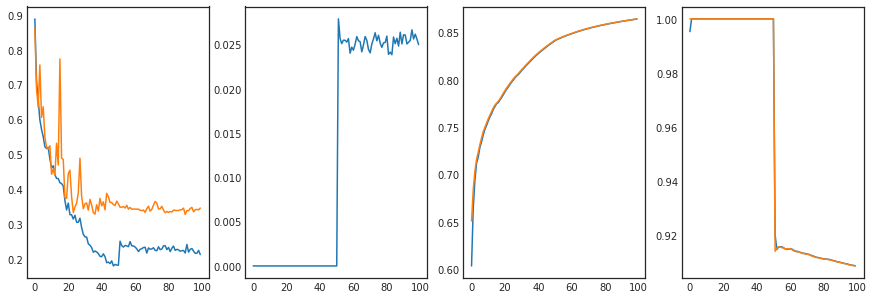

In [16]:
fig, (ax_loss, ax_temp_loss, ax_acc, ax_iou) = plt.subplots(1,4, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_temp_loss.plot(history.epoch, history.history["temperal_mse_loss"], label="Train loss")
# ax_temp_loss.plot(history.epoch, history.history["val_temperal_mse_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

# Fine tune threshold

In [17]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

# # used for predict, no dropout
temperal = Temperal_Callback()
model_predict = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.0, training=False)
model_predict.compile(loss=temperal.temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_predict.set_weights(model_train.get_weights())

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_predict.predict(X_valid, batch_size=32, verbose=1)

800/800 [==============================] - 2s 3ms/step


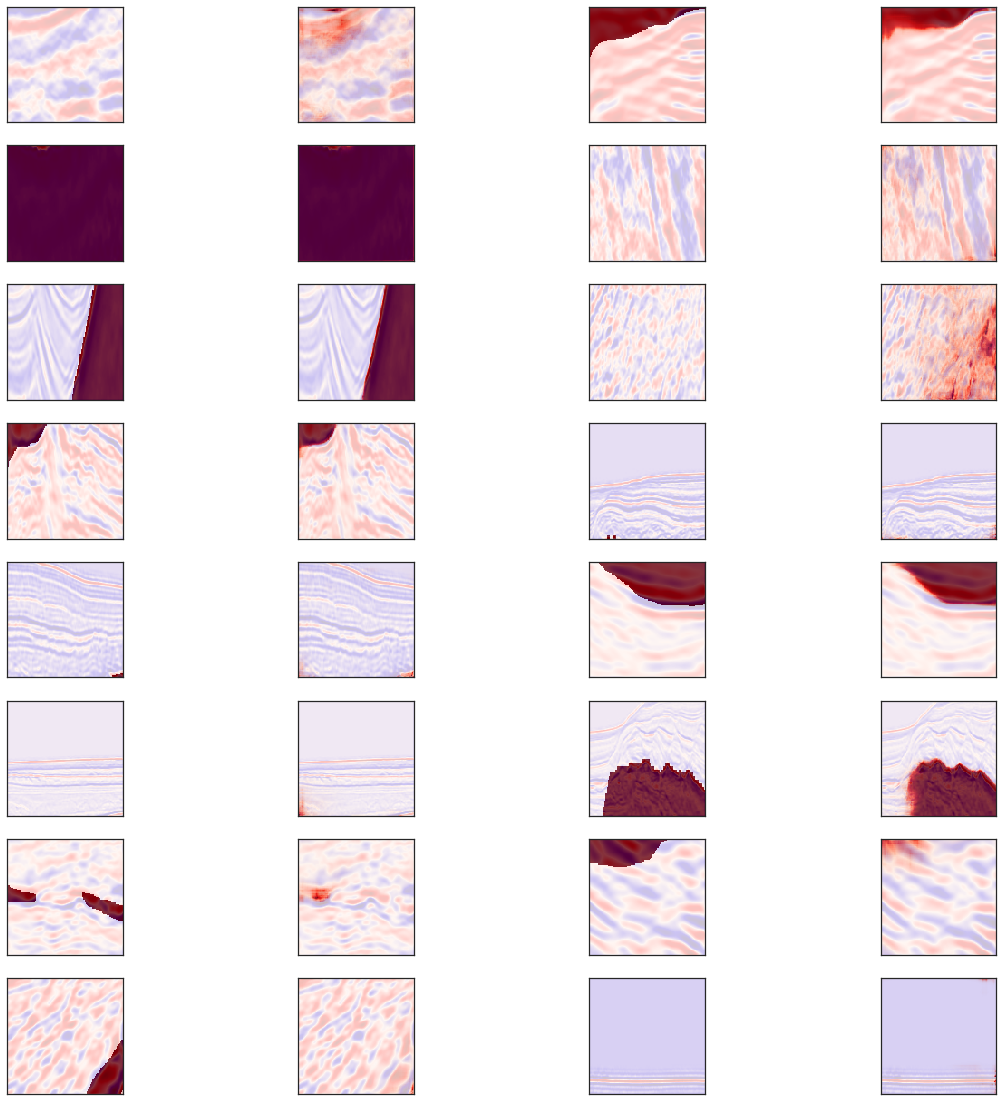

In [18]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


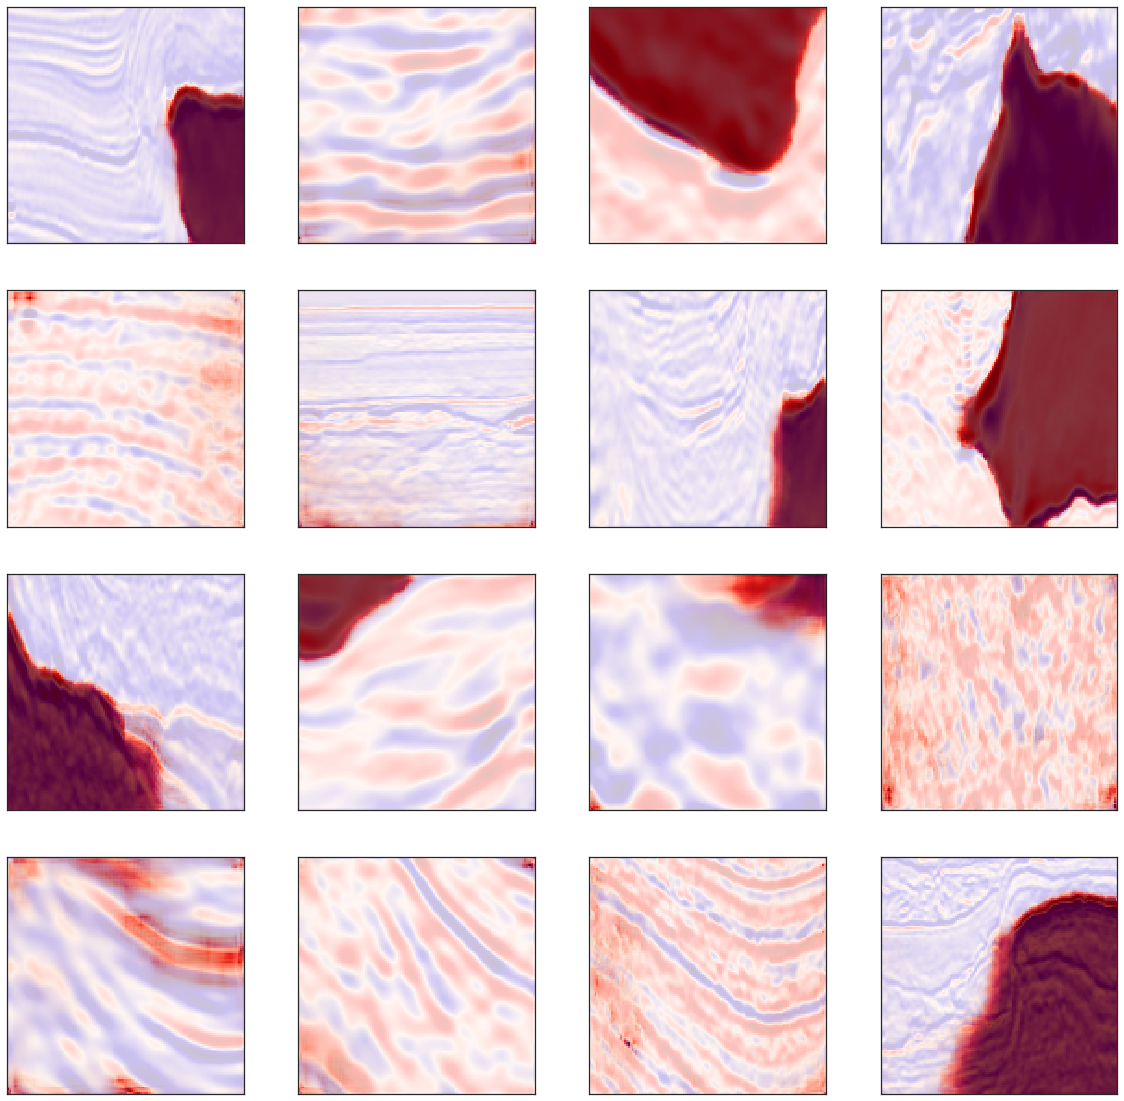

In [19]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [20]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.5789473684210527, iou_best: 0.760625


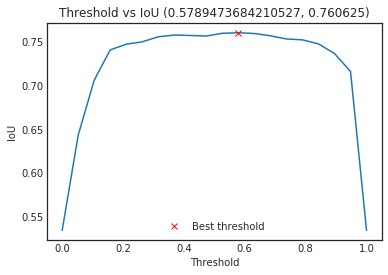

In [21]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Predict test data

In [22]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [23]:
X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
preds_test = model_predict.predict(X_test, batch_size=32, verbose=1)
final_preds_test = preds_test > threshold_best

3600/3600 [==============================] - 7s 2ms/step


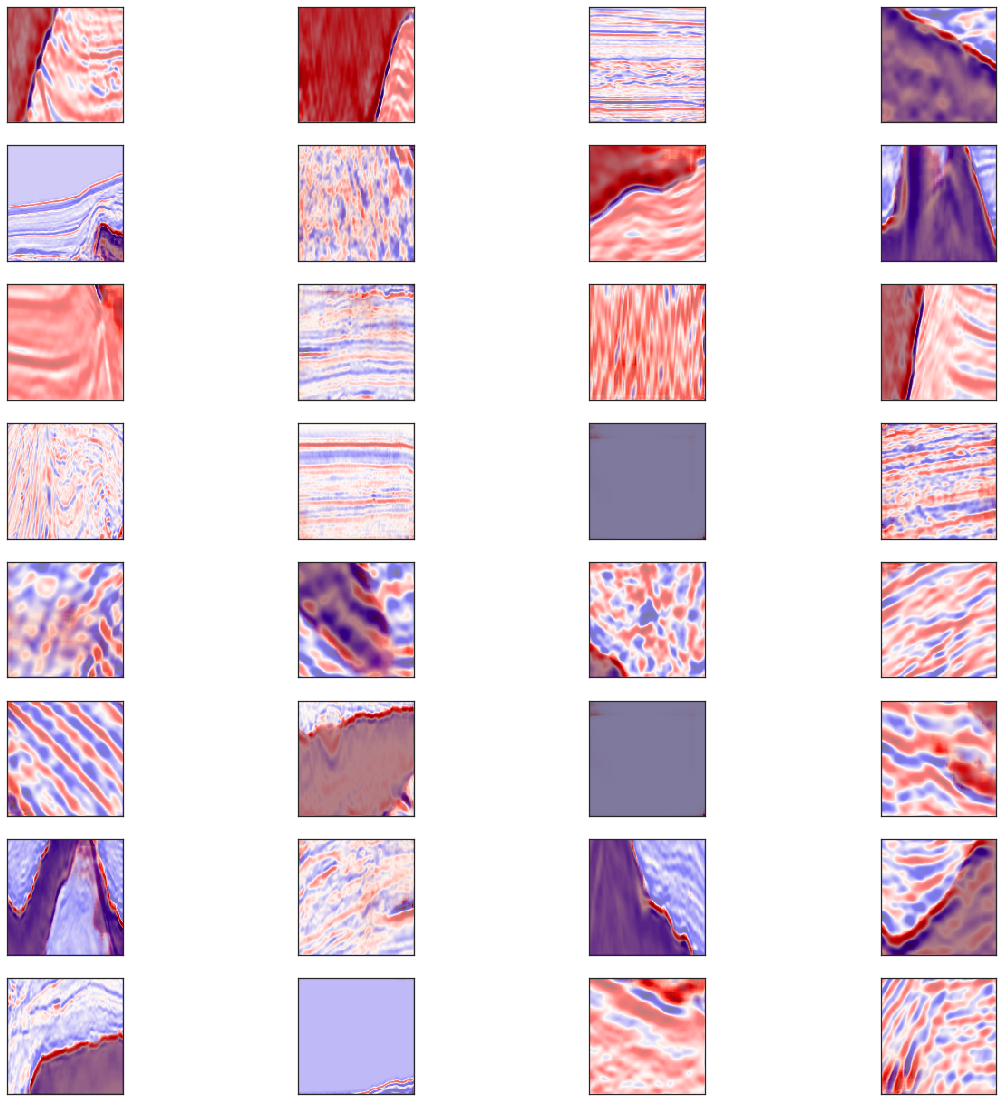

In [24]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

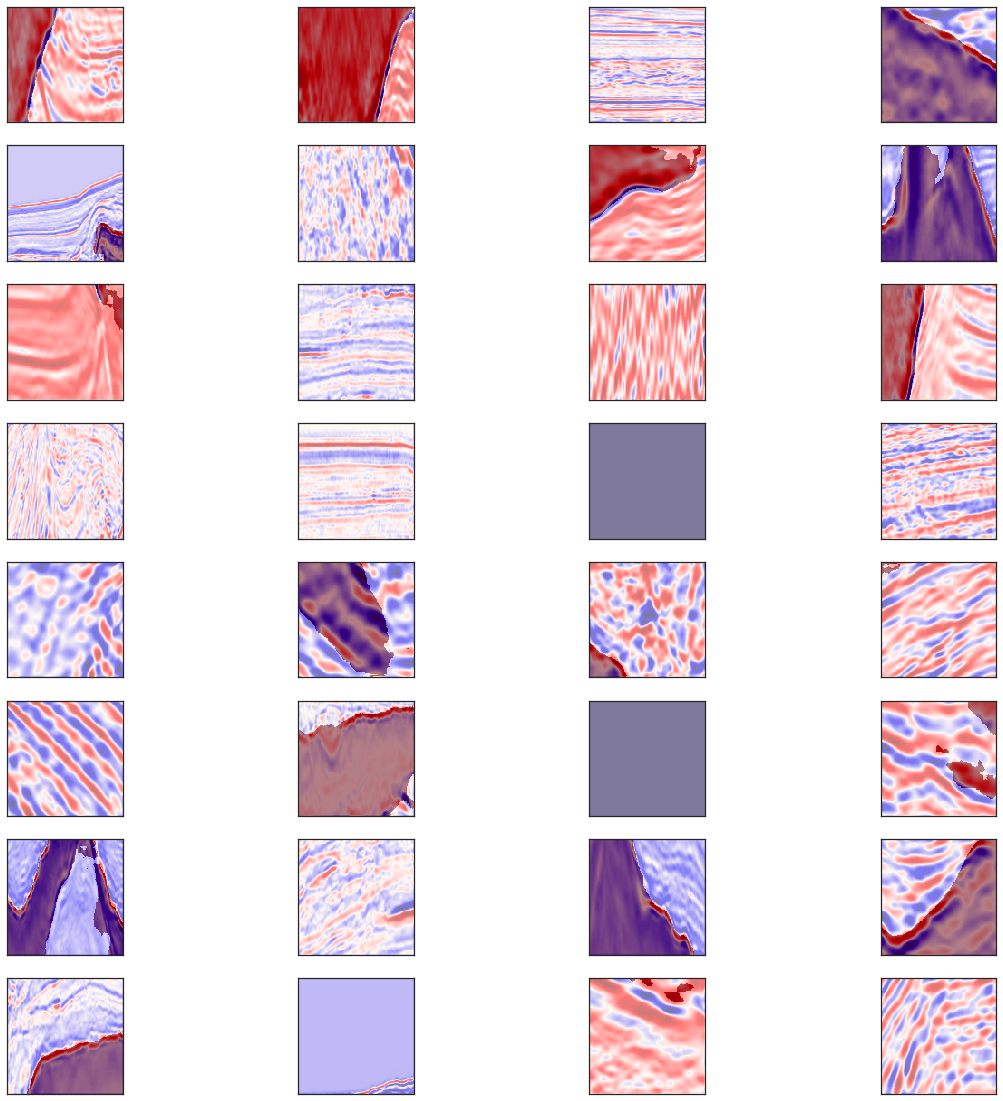

In [25]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = final_preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

# Apply CRF

In [26]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [27]:
"""
Applying CRF on the predicted mask 

"""
crf_output = []
for i in tqdm(range(X_test.shape[0])):
    crf_output.append(crf(np.squeeze(X_test[i]),np.squeeze(final_preds_test[i])))

100%|██████████| 3600/3600 [01:33<00:00, 38.32it/s]


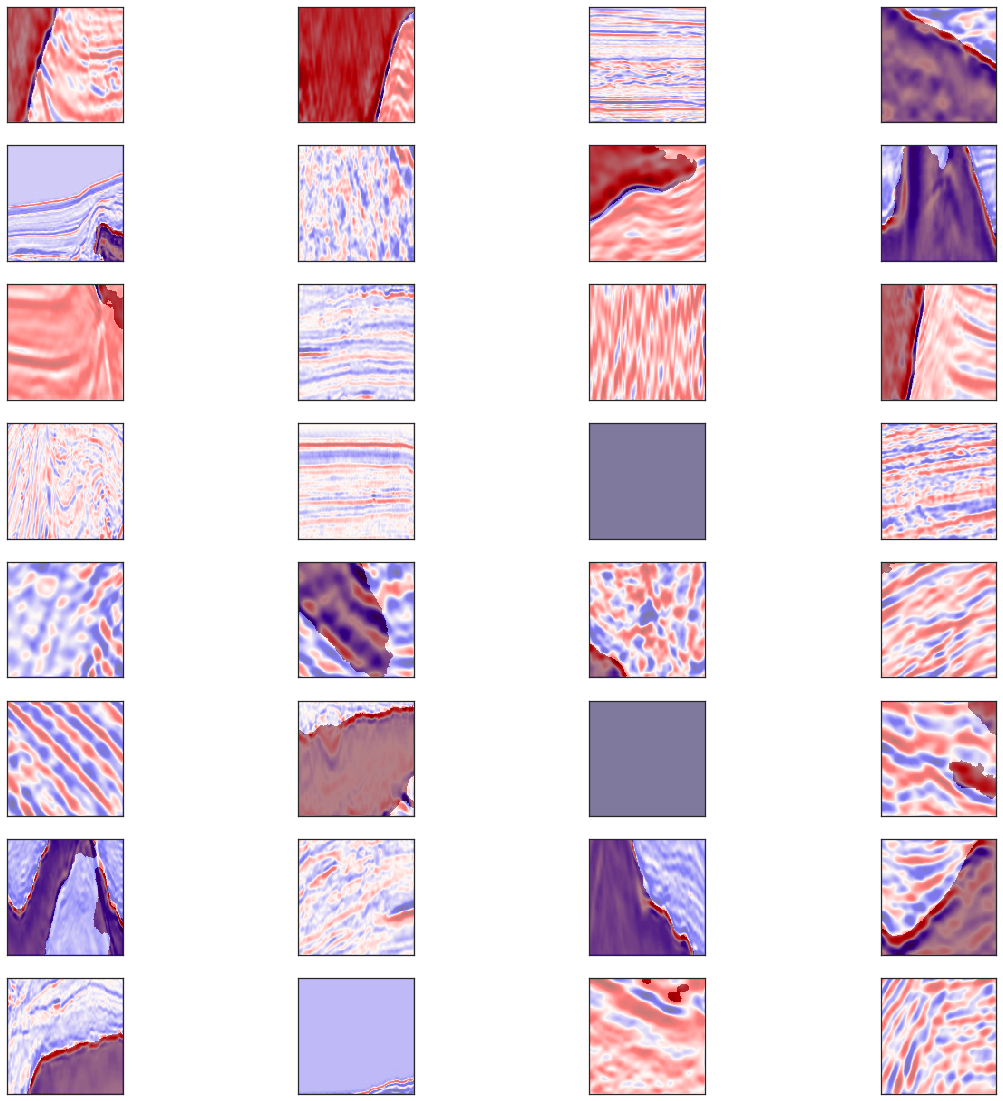

In [28]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = crf_output[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

In [29]:
threshold_best=threshold_best
pred_dict = {idx: RLenc(np.round(downsample(crf_output[i]))) for i, idx in enumerate(tqdm_notebook(test_df.img_id.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_pinet_crf.csv')